In [1]:
import json
import os
from os import path as osp
import pandas as pd
import numpy as np
from PIL import Image
import re

In [2]:
split = 'dev'

# download annotations from here and put them in nlxgpt/data :
# https://drive.google.com/drive/folders/16sJjeEQE2o23G-GGUi870ubXzJjdRDua
# (cf. nlxgpt/README.md -> Annotations Download -> VQA-X link)

ann_dir = osp.abspath('../data/')
sample_dir = osp.abspath('../generated/')
img_dir = 'PATH'  # insert path to CLEVR images here (CLEVR_v1.0/images/)

# Preparation

## Read Annotations

In [3]:
def load_json(file): 
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def get_confident_answers(list_of_answers): 
    return [x for x in list_of_answers if x['answer_confidence'] == 'yes']

def majority_vote(list_of_answers):
    answers = [a['answer'] for a in list_of_answers]
    return max(set(answers), key=answers.count)

In [4]:
with open(osp.join(ann_dir, f'CLEVRX_{split}.json')) as f:
    annotations = pd.DataFrame(json.load(f)['questions']).set_index('question_index')

## Read & Prepare Samples

In [5]:
def process_sample_file(filename):
    samples_df = pd.read_json(filename)
    
    # rename question id column & set as index
    samples_df = samples_df.rename(columns={'image_id': 'question_id'}).set_index('question_id')

    # split answers from predictions (and collect idx of entries where this doesn't work)
    samples_df['answers_explanations'] = samples_df.caption.map(lambda x: x.split(' because '))
    invalid_ids = samples_df[samples_df.answers_explanations.map(len) != 2].index
    # restrict to valid samples
    samples_df = samples_df[np.logical_not(samples_df.index.isin(invalid_ids))]

    # separate columns for answers and explanations
    samples_df['answer'] = samples_df.answers_explanations.map(lambda x: x[0])
    samples_df['explanation'] = samples_df.answers_explanations.map(lambda x: x[1])
    samples_df = samples_df.drop(columns=['answers_explanations'])
    
    return samples_df, invalid_ids.to_list()

def is_correct_answer(entry, annotations):
    answer = entry.answer
    question_id = entry.name
    # return true if predicted answer matches the annotation
    return answer == annotations.loc[question_id].answer

In [6]:
sample_fname = 'clevrx_unf_captions_full_2_val_greyscale.json'
sample_file = osp.join(sample_dir, sample_fname)
samples_df, invalid_ids = process_sample_file(sample_file)

In [7]:
# determine correctness of predicted answers
samples_df['correct_answer'] = samples_df.apply(lambda x: is_correct_answer(x, annotations), axis=1)
print('clr acc:', round(sum(samples_df.correct_answer) / len(samples_df), 2))

clr acc: 0.57


# show examples

In [8]:
_anns = annotations.rename(columns={'answer': 'ann_answer', 'factual_explanation': 'ann_explanations'})[['question', 'image_filename', 'image_index', 'ann_answer', 'ann_explanations']]

examples = pd.merge(
    samples_df,
    _anns,
    left_index=True,
    right_index=True
)


In [9]:
def show_example(entry, base_img_dir=img_dir):
    img_fname = entry.image_filename
    split = re.search(r'CLEVR_([a-z]+)_\d+.png', img_fname).group(1)
    img_path = osp.join(base_img_dir, split, img_fname)

    print(f'Q {entry.name} / Image {entry.image_index} / {entry.image_filename}\n')
    
    display(Image.open(img_path))    
    
    # print entries
    print(entry.question, '\n')
    
    print('Predictions:')
    for c in ['answer', 'explanation', 'correct_answer']:
        print(f'\t{c.ljust(15)}\t{entry[c]}')
    print('\n')
    
    print(f'Ann.Answer\t{entry["ann_answer"]}')
    for i, exp in enumerate(entry["ann_explanations"]):
        print(f'Explanation {i+1}\t{exp}')
    
    print(f'\n{"="*25}\n')

Q 137380 / Image 13738 / CLEVR_train_013738.png



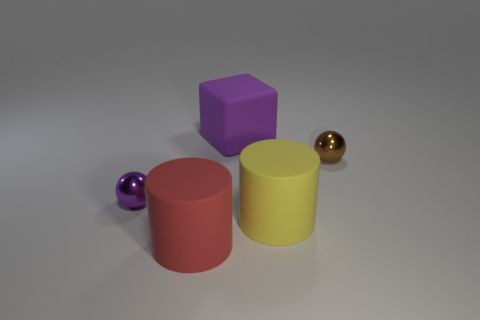

There is a big purple block; are there any big purple rubber cubes behind it? 

Predictions:
	answer         	no
	explanation    	there are no big purple rubber cubes which are behind the big purple block
	correct_answer 	True


Ann.Answer	no
Explanation 1	There are no big purple rubber cubes that are behind the big purple block.
Explanation 2	There are no big purple rubber cubes which are behind the big purple block.


Q 105104 / Image 10511 / CLEVR_train_010511.png



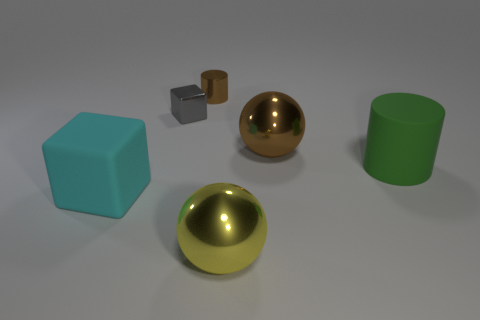

Do the cylinder that is behind the gray metal thing and the thing right of the big brown ball have the same material? 

Predictions:
	answer         	yes
	explanation    	the cylinder behind the gray metal ball is matte and the cylinder to the right of the big
	correct_answer 	False


Ann.Answer	no
Explanation 1	There is a metal cylinder which is behind the gray metal cube and there is a rubber cylinder which is to the right of the big brown ball.
Explanation 2	The cylinder behind the gray metal block is metal and the cylinder to the right of the big brown ball is rubber.
Explanation 3	The cylinder behind the gray metal cube is metal and the cylinder on the right side of the big brown ball is matte.
Explanation 4	The cylinder behind a gray metal cube is metallic and the cylinder on the right side of a big brown ball is matte.
Explanation 5	The cylinder behind the gray metal cube is metallic and the cylinder on the right side of the big brown ball is matte.
Explanation 6	The cylinder be

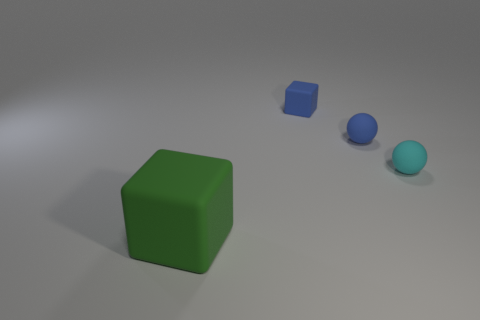

There is a matte block to the right of the cube to the left of the cube that is behind the green matte object; what color is it? 

Predictions:
	answer         	gray
	explanation    	there is a gray matte block which is on the right side of the cube that is left
	correct_answer 	False


Ann.Answer	blue
Explanation 1	There is a blue matte block which is to the right of the cube that is left of the cube that is behind the green matte cube.
Explanation 2	There is a blue matte block that is right of the cube that is left of the cube that is behind the green matte cube.
Explanation 3	There is a blue matte block that is to the right of the cube that is left of the cube that is behind the green matte cube.
Explanation 4	There is a blue matte block which is on the right side of the cube that is left of the cube that is behind the green matte cube.


Q 471916 / Image 47192 / CLEVR_train_047192.png



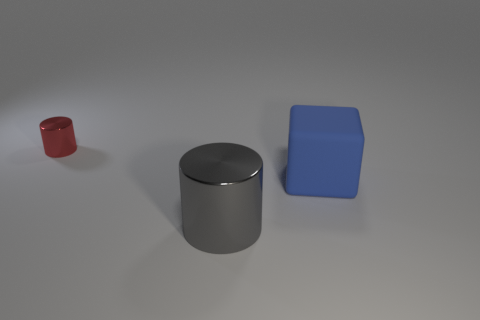

What shape is the metal thing behind the big block? 

Predictions:
	answer         	cylinder
	explanation    	the metal object behind the big block is a cylinder
	correct_answer 	True


Ann.Answer	cylinder
Explanation 1	There is a metal cylinder which is behind the big block.
Explanation 2	The metal object behind the big block is a cylinder.
Explanation 3	The metal thing behind the big block is a cylinder.
Explanation 4	There is a metal cylinder that is behind the big block.


Q 531781 / Image 53179 / CLEVR_train_053179.png



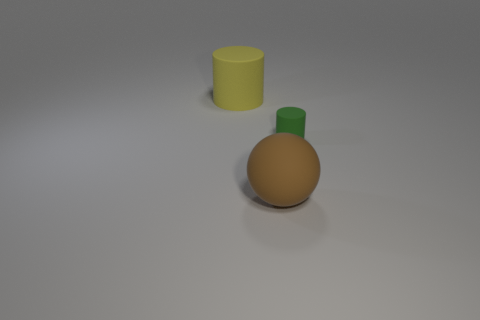

What number of other things are the same size as the brown object? 

Predictions:
	answer         	1
	explanation    	there is the tiny cylinder which has the identical size as a brown cylinder
	correct_answer 	True


Ann.Answer	1
Explanation 1	There is the big cylinder which has the identical size as a brown ball.
Explanation 2	The large cylinder has the same size as a brown sphere.
Explanation 3	There is the large cylinder that has the same size as a brown sphere.
Explanation 4	There is a big cylinder which has the identical size as a brown ball.
Explanation 5	The big cylinder has the same size as a brown ball.


Q 46307 / Image 4630 / CLEVR_train_004630.png



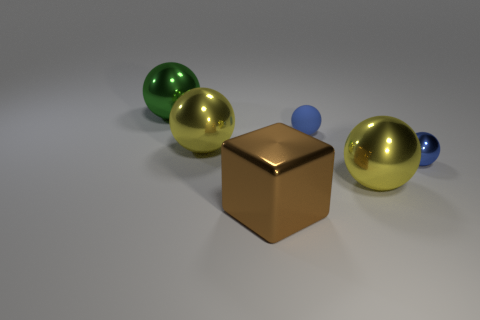

Are there any yellow metallic things on the left side of the brown cube? 

Predictions:
	answer         	no
	explanation    	there are no yellow metallic things that are left of the brown cube
	correct_answer 	False


Ann.Answer	yes
Explanation 1	There is a yellow metallic sphere that is left of the brown cube.
Explanation 2	There is a yellow metallic ball which is on the left side of the brown cube.
Explanation 3	There is a yellow metallic ball which is to the left of the brown cube.


Q 541075 / Image 54108 / CLEVR_train_054108.png



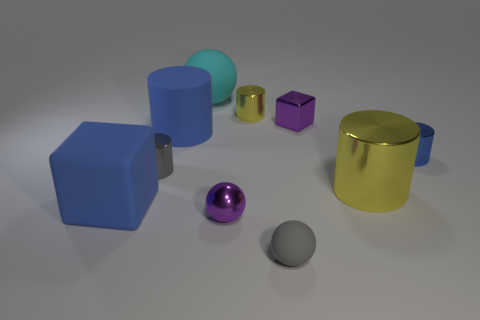

The cylinder that is behind the blue metallic cylinder and to the right of the cyan sphere is made of what material? 

Predictions:
	answer         	metal
	explanation    	there is a shiny cylinder behind the blue metallic cylinder and on the right side of the cyan
	correct_answer 	True


Ann.Answer	metal
Explanation 1	There is a metal cylinder behind the blue metallic cylinder and right of the cyan sphere.
Explanation 2	There is a shiny cylinder behind the blue metallic cylinder and on the right side of the cyan sphere.
Explanation 3	There is a metallic cylinder behind the blue metallic cylinder and to the right of the cyan sphere.
Explanation 4	There is a shiny cylinder behind the blue metallic cylinder and to the right of the cyan sphere.


Q 167838 / Image 16784 / CLEVR_train_016784.png



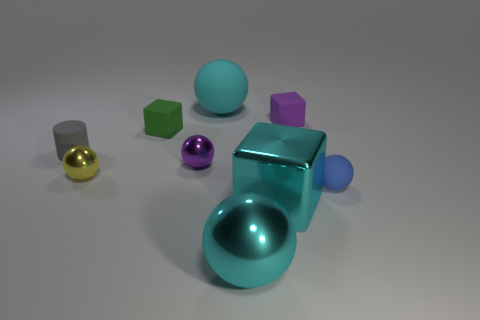

The cylinder has what color? 

Predictions:
	answer         	gray
	explanation    	the cylinder is gray
	correct_answer 	True


Ann.Answer	gray
Explanation 1	The cylinder is gray.
Explanation 2	There is a gray cylinder.


Q 224831 / Image 22483 / CLEVR_train_022483.png



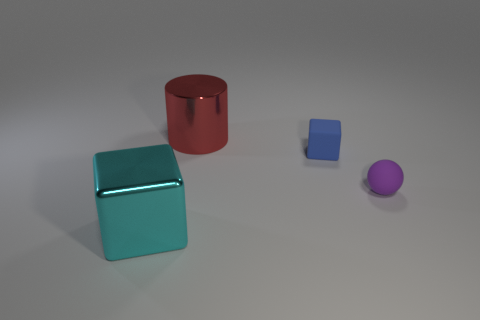

How many things are cyan blocks or rubber things that are in front of the rubber block? 

Predictions:
	answer         	1
	explanation    	there is a rubber ball which is in front of the rubber block
	correct_answer 	False


Ann.Answer	2
Explanation 1	There is a cyan block and there is a rubber ball which is in front of the rubber block.
Explanation 2	There is a cyan block and there is a rubber sphere that is in front of the rubber block.


Q 98947 / Image 9895 / CLEVR_train_009895.png



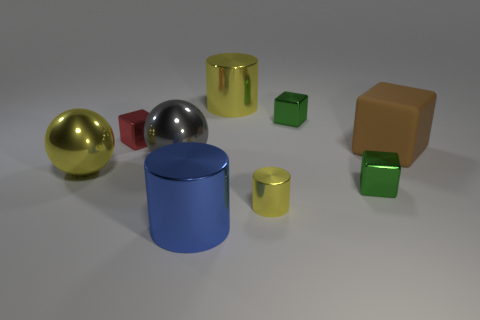

What number of yellow objects are metal objects or large things? 

Predictions:
	answer         	0
	explanation    	there are no yellow things
	correct_answer 	False


Ann.Answer	3
Explanation 1	There are two yellow cylinders and a yellow sphere.


Q 599591 / Image 59960 / CLEVR_train_059960.png



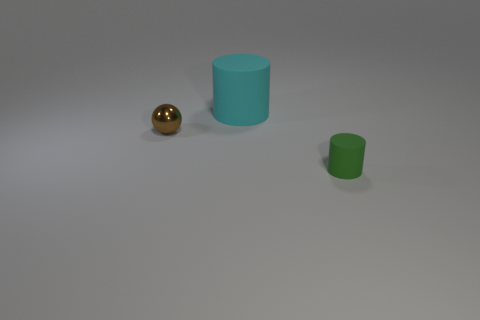

Is there a small shiny ball that is behind the matte object behind the small brown ball? 

Predictions:
	answer         	no
	explanation    	there are no small shiny balls which are behind the matte cylinder that is behind the small brown
	correct_answer 	True


Ann.Answer	no
Explanation 1	There are no small shiny balls that are behind the matte cylinder that is behind the small brown ball.
Explanation 2	There are no small shiny balls which are behind the matte cylinder that is behind the small brown ball.


Q 309410 / Image 30942 / CLEVR_train_030942.png



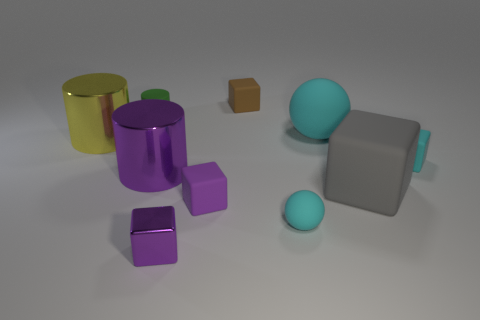

There is a big cube; is it the same color as the cylinder that is behind the large rubber ball? 

Predictions:
	answer         	yes
	explanation    	there is a big gray cube and there is a gray cylinder that is behind the large rubber
	correct_answer 	False


Ann.Answer	no
Explanation 1	The big cube is gray and the cylinder behind the large rubber ball is green.
Explanation 2	There is a big gray cube and there is a green cylinder that is behind the large rubber ball.
Explanation 3	There is a big gray cube and there is a green cylinder which is behind the large rubber ball.


Q 472143 / Image 47215 / CLEVR_train_047215.png



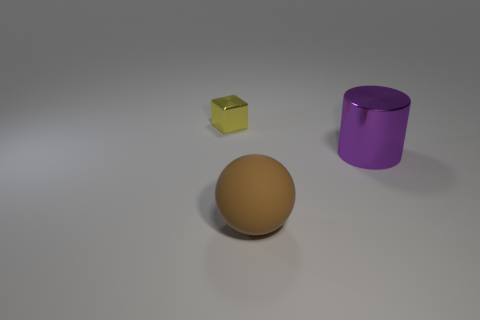

Does the brown object have the same size as the metallic block? 

Predictions:
	answer         	yes
	explanation    	the brown ball is tiny and the metallic block is tiny
	correct_answer 	False


Ann.Answer	no
Explanation 1	There is a large brown ball and there is a tiny metallic block.
Explanation 2	The brown sphere is large and the metallic block is small.
Explanation 3	There is a big brown ball and there is a small metallic block.
Explanation 4	There is a big brown sphere and there is a small metallic block.
Explanation 5	The brown ball is large and the metallic block is small.
Explanation 6	There is a large brown sphere and there is a small metallic block.
Explanation 7	There is a large brown ball and there is a small metallic block.


Q 639238 / Image 63924 / CLEVR_train_063924.png



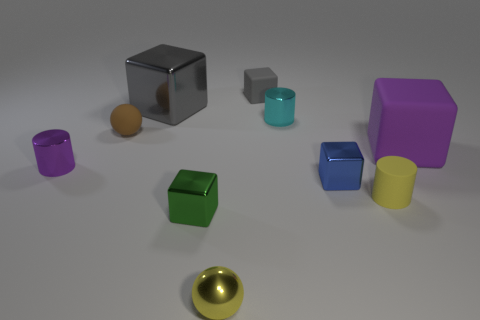

Does the small gray thing have the same shape as the purple thing that is to the left of the yellow metal thing? 

Predictions:
	answer         	no
	explanation    	the small gray thing is a cylinder and the purple object on the left side of the yellow
	correct_answer 	True


Ann.Answer	no
Explanation 1	The small gray object is a block and the purple thing on the left side of the yellow metal ball is a cylinder.
Explanation 2	The small gray thing is a block and the purple thing on the left side of a yellow metal ball is a cylinder.
Explanation 3	The small gray thing is a block and the purple object left of the yellow metal sphere is a cylinder.
Explanation 4	The small gray thing is a cube and the purple object left of the yellow metal sphere is a cylinder.
Explanation 5	There is a small gray cube and there is a purple cylinder which is on the left side of the yellow metal sphere.
Explanation 6	The small gray thing is a block and the purple thing left of a yellow metal sphere is a cylin

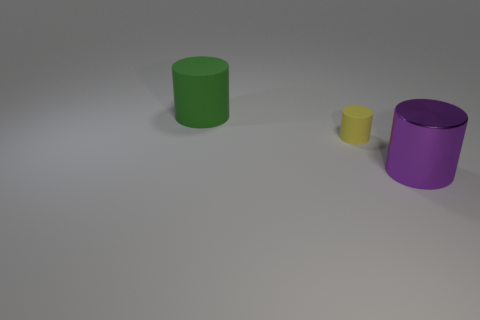

There is a tiny yellow thing that is in front of the big cylinder that is behind the big purple shiny object; what is it made of? 

Predictions:
	answer         	rubber
	explanation    	there is a tiny yellow matte cylinder which is in front of the big cylinder that is behind
	correct_answer 	True


Ann.Answer	rubber
Explanation 1	There is a tiny yellow matte cylinder which is in front of the big cylinder that is behind the big purple shiny cylinder.
Explanation 2	There is a tiny yellow rubber cylinder that is in front of the big cylinder that is behind the big purple shiny cylinder.


Q 232736 / Image 23274 / CLEVR_train_023274.png



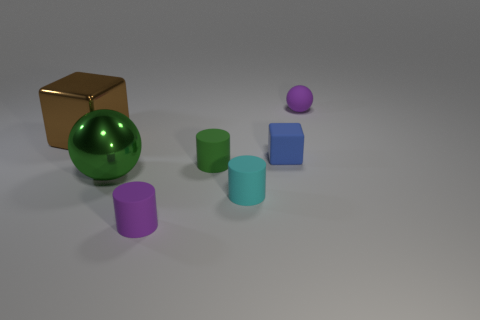

There is a tiny ball; is its color the same as the big metal thing behind the blue object? 

Predictions:
	answer         	yes
	explanation    	the tiny ball is gray and the big metal block behind the blue block is gray
	correct_answer 	False


Ann.Answer	no
Explanation 1	There is a tiny purple ball and there is a big brown metal cube that is behind the blue cube.
Explanation 2	The tiny ball is purple and the big metal block behind a blue block is brown.
Explanation 3	There is a tiny purple ball and there is a big brown metal block which is behind the blue cube.
Explanation 4	The tiny ball is purple and the big metal block behind the blue block is brown.
Explanation 5	The tiny ball is purple and the big metal cube behind the blue cube is brown.


Q 671334 / Image 67134 / CLEVR_train_067134.png



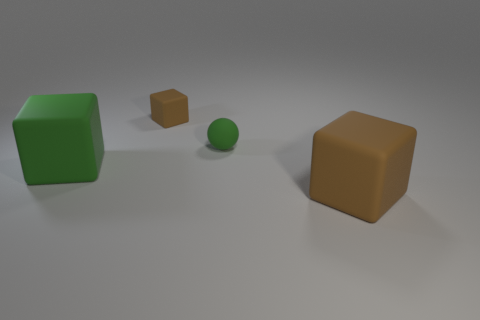

There is a green cube; how many cubes are right of it? 

Predictions:
	answer         	1
	explanation    	there is a cube that is right of the green cube
	correct_answer 	False


Ann.Answer	2
Explanation 1	There are two cubes that are right of the green cube.
Explanation 2	There are two cubes which are on the right side of the green cube.
Explanation 3	There are two cubes which are to the right of the green cube.


Q 563721 / Image 56373 / CLEVR_train_056373.png



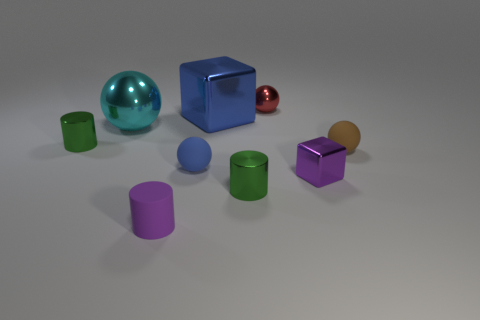

How many large cyan things are the same shape as the big blue thing? 

Predictions:
	answer         	0
	explanation    	there are no large cyan things that have the same shape as a big blue sphere
	correct_answer 	True


Ann.Answer	0
Explanation 1	There are no large cyan things that have the same shape as a big blue cube.
Explanation 2	There are no large cyan things which have the identical shape as a big blue block.
Explanation 3	No large cyan things have the same shape as a big blue block.


Q 48439 / Image 4843 / CLEVR_train_004843.png



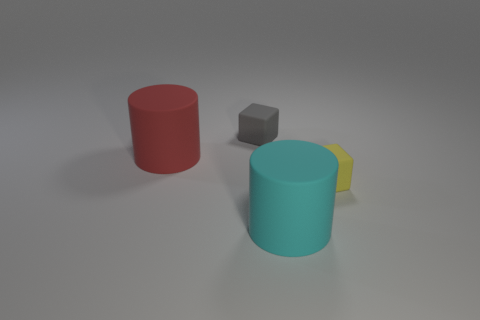

There is a large cyan rubber object; what shape is it? 

Predictions:
	answer         	cylinder
	explanation    	the large cyan rubber thing is a cylinder
	correct_answer 	True


Ann.Answer	cylinder
Explanation 1	There is a large cyan rubber cylinder.
Explanation 2	The large cyan rubber thing is a cylinder.


Q 324539 / Image 32455 / CLEVR_train_032455.png



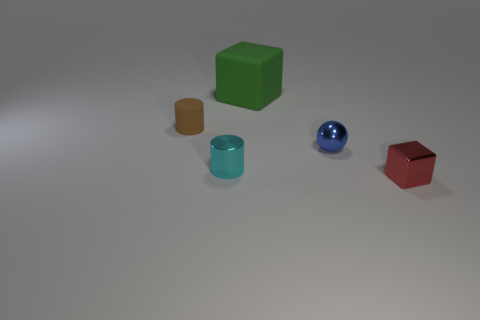

How many large objects are brown matte things or green rubber blocks? 

Predictions:
	answer         	0
	explanation    	there are no large things
	correct_answer 	False


Ann.Answer	1
Explanation 1	There is a large cube.
Explanation 2	There is a large block.





In [10]:
examples.sample(20).apply(lambda x: show_example(x), axis=1)
print()

# Success rate and color terms

In [11]:
COLOR_TERMS = ['black', 'white', 'red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey', 'gray']
COLOR_CATS = ['color', 'colour']

def contains_color_cat(s):
    q = r'|'.join(COLOR_CATS)
    return True if re.search(q, s, re.IGNORECASE) else False

def contains_color_term(s):
    q = r'|'.join(COLOR_TERMS)
    return True if re.search(q, s, re.IGNORECASE) else False

def get_acc_for_mask(df, mask_series):
    _df = df.loc[mask_series]
    if len(_df) == 0:
        # prevent zero division error
        return -1
    acc = sum(_df.correct_answer) / len(_df)
    return acc

In [12]:
cat_in_q = examples.question.map(contains_color_cat)
cat_in_exp = examples.explanation.map(contains_color_cat)
cat_in_ans = examples.answer.map(contains_color_cat)

term_in_q = examples.question.map(contains_color_term)
term_in_exp = examples.explanation.map(contains_color_term)
term_in_ans = examples.answer.map(contains_color_term)

clr_in_any = cat_in_q | cat_in_exp | cat_in_ans | term_in_q | term_in_exp | term_in_ans

print(f'{"clr_in_any".ljust(11)} : {round(sum(clr_in_any / len(examples)), 2)}')
print(f'{"cat_in_q".ljust(11)} : {round(sum(cat_in_q / len(examples)), 2)}')
print(f'{"cat_in_exp".ljust(11)} : {round(sum(cat_in_exp / len(examples)), 2)}')
print(f'{"cat_in_ans".ljust(11)} : {round(sum(cat_in_ans / len(examples)), 2)}')
print(f'{"term_in_q".ljust(11)} : {round(sum(term_in_q / len(examples)), 2)}')
print(f'{"term_in_exp".ljust(11)} : {round(sum(term_in_exp / len(examples)), 2)}')
print(f'{"term_in_ans".ljust(11)} : {round(sum(term_in_ans / len(examples)), 2)}')

clr_in_any  : 0.9
cat_in_q    : 0.21
cat_in_exp  : 0.08
cat_in_ans  : 0.0
term_in_q   : 0.77
term_in_exp : 0.81
term_in_ans : 0.09


In [13]:
baseline_acc = sum(examples.correct_answer) / len(examples)
clr_in_any_acc = get_acc_for_mask(examples, clr_in_any)
cat_in_q_acc = get_acc_for_mask(examples, cat_in_q)
cat_in_exp_acc = get_acc_for_mask(examples, cat_in_exp)
cat_in_ans_acc = get_acc_for_mask(examples, cat_in_ans)
term_in_q_acc = get_acc_for_mask(examples, term_in_q)
term_in_exp_acc = get_acc_for_mask(examples, term_in_exp)
term_in_ans_acc = get_acc_for_mask(examples, term_in_ans)

print(f'acc {"".ljust(11)} : {round(baseline_acc, 2)}')
print(f'acc {"clr_in_any".ljust(11)} : {round(clr_in_any_acc, 2)}')
print(f'acc {"cat_in_q".ljust(11)} : {round(cat_in_q_acc, 2)}')
print(f'acc {"cat_in_exp".ljust(11)} : {round(cat_in_exp_acc, 2)}')
print(f'acc {"cat_in_ans".ljust(11)} : {round(cat_in_ans_acc, 2)}')
print(f'acc {"term_in_q".ljust(11)} : {round(term_in_q_acc, 2)}')
print(f'acc {"term_in_exp".ljust(11)} : {round(term_in_exp_acc, 2)}')
print(f'acc {"term_in_ans".ljust(11)} : {round(term_in_ans_acc, 2)}')

acc             : 0.57
acc clr_in_any  : 0.55
acc cat_in_q    : 0.35
acc cat_in_exp  : 0.54
acc cat_in_ans  : -1
acc term_in_q   : 0.57
acc term_in_exp : 0.54
acc term_in_ans : 0.13
